Imports

In [1]:
import numpy as np
import csv
from PIL import Image
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import math

In [2]:
w = 101
h = 101

Reading in Training Data

In [3]:
import pickle
data = pickle.load(open("training_separated.p", 'rb'))
X = data[0]
y = data[1]

In [4]:
# Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
print("Training Shape")
print(X_train.shape)
print(y_train.shape)

print("Testing Shape")
print(X_test.shape)
print(y_test.shape)

Training Shape
(5404, 101, 101, 1)
(5404, 2)
Testing Shape
(954, 101, 101, 1)
(954, 2)


In [5]:
class PictureHelper():
    
    def __init__(self):
        self.i = 0

        self.training_images = X_train
        self.training_labels = y_train
        
        self.testing_images = X_test
        self.testing_labels = y_test
    
    def getTesting(self, batch_size):
        # shuffle data
        p = np.random.permutation(len(self.testing_images))
        self.testing_images = self.testing_images[p]
        self.testing_labels = self.testing_labels[p]   
        if (batch_size < self.testing_images.shape[0]):
            x = self.testing_images[:batch_size]
            y = self.testing_labels[:batch_size]
        else:
            x = self.testing_images
            y = self.testing_labels
        
        return x, y
        
        
    def next_batch(self, batch_size):
        
        if (self.i + batch_size >= self.training_images.shape[0]):
            p = numpy.random.permutation(len(self.training_images))
            self.training_images = self.training_images[p]
            self.training_labels = self.training_labels[p]
            
        x = self.training_images[self.i:self.i+batch_size]
        y = self.training_labels[self.i:self.i+batch_size]
            
        self.i = (self.i + batch_size) % len(self.training_images)
        
        return x, y

In [6]:
ph = PictureHelper()
x, y = ph.getTesting(10)
print(x.shape)
print(y.shape)

(10, 101, 101, 1)
(10, 2)


## Creating the Model

** Import tensorflow **

In [7]:
import tensorflow as tf

In [8]:
x = tf.placeholder(tf.float32,shape=[None,w,h,1])
y_true = tf.placeholder(tf.float32,shape=[None,2])

In [9]:
hold_prob = tf.placeholder(tf.float32)

In [10]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

# Framework Definition

In [36]:
convo_1 = convolutional_layer(x,shape=[2,2,1,128])
convo_2 = convolutional_layer(convo_1,shape=[2,2,128,128])
convo_2_pooling = max_pool_2by2(convo_2)

convo_3 = convolutional_layer(convo_2_pooling,shape=[2,2,128,128])
convo_4 = convolutional_layer(convo_3,shape=[2,2,128,128])
convo_4_pooling = max_pool_2by2(convo_4)

convo_5 = convolutional_layer(convo_4_pooling,shape=[2,2,128,128])
convo_6 = convolutional_layer(convo_5,shape=[2,2,128,128])
convo_7 = convolutional_layer(convo_6,shape=[2,2,128,64])
convo_7_pooling = max_pool_2by2(convo_7)

convo_8 = convolutional_layer(convo_7_pooling, shape=[2,2,64,256])
convo_9 = convolutional_layer(convo_8, shape=[2,2,256,256])
convo_10 = convolutional_layer(convo_9, shape=[2,2,256,128])
convo_10_pooling = max_pool_2by2(convo_10)

convo_11 = convolutional_layer(convo_10_pooling, shape=[2,2,128,256])
convo_12 = convolutional_layer(convo_11, shape=[2,2,256,256])
convo_13 = convolutional_layer(convo_12, shape=[2,2,256,128])

new_w = math.ceil(w / 16)
new_h = math.ceil(h / 16)

num_features = 128

convo_13_flat = tf.reshape(convo_13,[-1,new_h*new_w*num_features])

full_layer_1 = tf.nn.relu(normal_full_layer(convo_13_flat,1024))

full_layer_2 = tf.nn.relu(normal_full_layer(full_layer_1,1024))

full_dropout = tf.nn.dropout(full_layer_2,keep_prob=hold_prob)

y_pred = normal_full_layer(full_dropout,2)

# Optimization and Loss Function

In [37]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred)

optimizer = tf.train.AdamOptimizer(learning_rate=0.00001)
train = optimizer.minimize(cross_entropy)

init = tf.global_variables_initializer()

## Graph Session

** Perform the training and test print outs in a Tf session and run your model! **

In [38]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.90)

In [14]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3385777032719622104, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11280806708
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15653021730364466468
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [39]:
trainAct = []
trainPred = []

testAct = []
testPred = []

In [40]:
# config = tf.ConfigProto(gpu_options = gpu_options)
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(10000):
        ph = PictureHelper()
        batch = ph.next_batch(16)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.9})
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        if i%10 == 0:
            #print('Currently on step {}'.format(i))
            if (i%50 == 0):
                print('Currently on step {}'.format(i))
                
                x_test2, y_test2 = ph.getTesting(1000) # for testing data
                x_train2, y_train2 = ph.next_batch(1000) # for training data

                matches = tf.equal(tf.argmax(y_pred, axis = 1), tf.argmax(y_true, axis = 1))
                acc = tf.reduce_mean(tf.cast(matches,tf.float32))

                 # printing accuracy
                
                test_acc = sess.run(acc,feed_dict={x:x_test2, y_true:y_test2, hold_prob:1.0})
                train_acc = sess.run(acc, feed_dict = {x:x_train2, y_true:y_train2, hold_prob:1.0})
                print("Testing Accuracy: ")
                print(test_acc)
                
                print("Training Accuracy: ")
                print(train_acc)
                
                
                testPred.append(sess.run(y_pred, feed_dict = {x:x_test2, y_true:y_test2, hold_prob:1.0}))
                testAct.append(y_test2)
                
                trainPred.append(sess.run(y_pred, feed_dict = {x:x_train2, y_true:y_train2, hold_prob:1.0}))
                trainAct.append(y_train2)
                
                data = [testAct, testPred, trainAct, trainPred]
                pickle.dump(data, open('results.p', 'wb'))

Currently on step 0


ResourceExhaustedError: OOM when allocating tensor with shape[954,128,102,102] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: Conv2D_27 = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](Relu_28, Variable_60/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: Mean_70/_17 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_211_Mean_70", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'Conv2D_27', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/cldelahan/.local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/cldelahan/.local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/cldelahan/.local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/cldelahan/.local/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/cldelahan/.local/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "/home/cldelahan/.local/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/cldelahan/.local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/cldelahan/.local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/cldelahan/.local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/cldelahan/.local/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/cldelahan/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/cldelahan/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/cldelahan/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/cldelahan/.local/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/cldelahan/.local/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/cldelahan/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/cldelahan/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/cldelahan/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2901, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/cldelahan/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-36-b9950553f725>", line 2, in <module>
    convo_2 = convolutional_layer(convo_1,shape=[2,2,128,128])
  File "<ipython-input-10-41c92a076598>", line 19, in convolutional_layer
    return tf.nn.relu(conv2d(input_x, W) + b)
  File "<ipython-input-10-41c92a076598>", line 10, in conv2d
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
  File "/home/cldelahan/.local/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 956, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "/home/cldelahan/.local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/cldelahan/.local/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/home/cldelahan/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/home/cldelahan/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[954,128,102,102] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: Conv2D_27 = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](Relu_28, Variable_60/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: Mean_70/_17 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_211_Mean_70", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



# Analyzing Results

In [31]:
data = pickle.load(open('results.p', 'rb'))
actual = np.array(data[2])
predicted = np.array(data[3])
print("Predicted Shape")
print(predicted.shape)
print("Actual Shape")
print(actual.shape)
predicted = np.argmax(predicted, axis = 2)
actual = np.argmax(actual, axis = 2)

Predicted Shape
(23, 1000, 2)
Actual Shape
(23, 1000, 2)


In [32]:
print(predicted[-1][:15])
print(actual[-1][:15])

[1 1 1 0 0 1 0 1 0 0 0 0 0 1 0]
[1 1 1 0 1 1 0 1 0 0 1 0 1 0 0]


In [33]:
num_matches = []
for i in range(predicted.shape[0]):
    num_matches.append(predicted[i][predicted[i] == actual[i]].size)
num_matches = np.array(num_matches)
accuracy = num_matches / predicted.shape[1]

Text(0,0.5,'Accuracy')

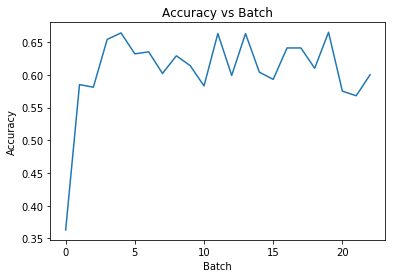

In [34]:
plt.plot(accuracy)
plt.title("Accuracy vs Batch")
plt.xlabel("Batch")
plt.ylabel("Accuracy")